In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from Data_handler import get_data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

WRDS recommends setting up a .pgpass file.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


# 1. Betting Against Beta

## Question a)

In [4]:
data = get_data()
Data = data.copy()

In [5]:
# Only keep permnos having more than 36 months of data
print("Original number of rows: ", Data.shape[0])
Data = Data.groupby('permno').filter(lambda permno: len(permno) >= 36)
print("Terminal number of rows: ", Data.shape[0])

display(Data.head())

Original number of rows:  1439408
Terminal number of rows:  1402358


,permno,date,ret,shrout,prc,siccd,tmytm,vwretd
0,10028,1992-06-30,-0.206897,5632.0,-1.43750,5094,0.002932,-0.019258
1,10028,1992-05-29,-0.205479,5548.0,-1.81250,5094,0.003034,0.006407
2,10028,1992-04-30,-0.170455,5548.0,-2.28125,5094,0.002924,0.013414
3,10028,1992-03-31,0.419355,5548.0,2.75000,5094,0.003348,-0.023699
4,10028,1998-05-29,0.047619,4151.0,2.75000,5094,0.003813,-0.025746


In [6]:
# Compute time varying beta for each stock
Data["date"] = pd.to_datetime(Data["date"], format = "%Y-%m-%d") # set date in the correct format

Data["Rm_e"] = Data["vwretd"] - Data["tmytm"]
Data["R_e"]  = Data["ret"] - Data["tmytm"]

# From PS_5_solution
cov_nm = Data.set_index('date').groupby('permno')[['R_e','Rm_e']].rolling(60, min_periods=36).cov()
beta_n = (cov_nm.iloc[1::2,1].droplevel(2)/cov_nm.iloc[0::2,1].droplevel(2))
beta_n = beta_n.dropna().reset_index().rename(columns={'Rm_e':'beta'})
beta_n['date'] = beta_n['date'] + pd.DateOffset(months=1)

# Data_beta = pd.merge(Data, beta_n, on=['date','permno'], how='left')
# display(Data_beta)

Data_beta = pd.merge(
    left = Data,
    right = beta_n,
    on = ["date", "permno"],
    how = "left"
)

# Winsorize at 95%
Data_beta['beta'] = Data_beta['beta'].clip(Data_beta['beta'].quantile(0.05), Data_beta['beta'].quantile(0.95))

In [7]:
display(Data_beta.head())

,permno,date,ret,shrout,prc,siccd,tmytm,vwretd,Rm_e,R_e,beta
0,10028,1992-06-30,-0.206897,5632.0,-1.43750,5094,0.002932,-0.019258,-0.022190,-0.209829,NaN
1,10028,1992-05-29,-0.205479,5548.0,-1.81250,5094,0.003034,0.006407,0.003373,-0.208513,NaN
2,10028,1992-04-30,-0.170455,5548.0,-2.28125,5094,0.002924,0.013414,0.010490,-0.173379,NaN
3,10028,1992-03-31,0.419355,5548.0,2.75000,5094,0.003348,-0.023699,-0.027047,0.416007,NaN
4,10028,1998-05-29,0.047619,4151.0,2.75000,5094,0.003813,-0.025746,-0.029559,0.043806,NaN


## Question b)

In [8]:
data_Qb = Data_beta.copy().dropna()
print(Data_beta.shape)
print(data_Qb.shape)

(1402358, 11)
(412246, 11)


In [9]:
data_Qb["monthly_decile"] = data_Qb.groupby("date")["beta"].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

data_Qb["monthly_return"] = data_Qb.groupby(["date", "monthly_decile"])["ret"].transform("mean")

display(data_Qb.sample(30))

,permno,date,ret,shrout,prc,siccd,tmytm,vwretd,Rm_e,R_e,beta,monthly_decile,monthly_return
184340,18650,1997-05-30,-0.102564,4977.0,4.375,3533,0.003685,0.071640,0.067955,-0.106249,2.077940,7,0.063318
481935,33830,1980-06-30,-0.057143,866.0,8.250,3662,0.005181,0.037714,0.032533,-0.062324,0.679400,1,0.046982
1379019,91683,2017-08-31,-0.081068,131374.0,18.590,5999,0.000926,0.001600,0.000674,-0.081994,0.695362,3,-0.029573
1112901,75091,1989-11-30,-0.076923,3660.0,13.500,4953,0.005909,0.017816,0.011907,-0.082832,0.545127,1,0.004997
397460,28484,2007-08-31,0.002778,317991.0,61.370,2911,0.003466,0.011593,0.008127,-0.000688,0.913035,5,-0.006333
571781,39140,1964-09-30,-0.004739,1244.0,-26.250,3792,0.002941,0.030480,0.027539,-0.007680,0.884981,6,0.035503
565136,38869,1976-09-30,0.067416,2927.0,-11.875,3811,0.004244,0.024513,0.020269,0.063172,1.168013,7,0.006898
50062,11703,1968-02-29,-0.001603,46168.0,154.500,2892,0.003902,-0.033624,-0.037526,-0.005505,2.221586,9,-0.007182
331979,25419,2012-04-30,-0.167057,77257.0,64.020,3633,0.000063,-0.006829,-0.006892,-0.167120,0.581437,1,-0.033604
362042,26841,1970-04-30,-0.123846,3694.0,8.375,5812,0.005441,-0.105318,-0.110759,-0.129287,0.641630,3,-0.191199


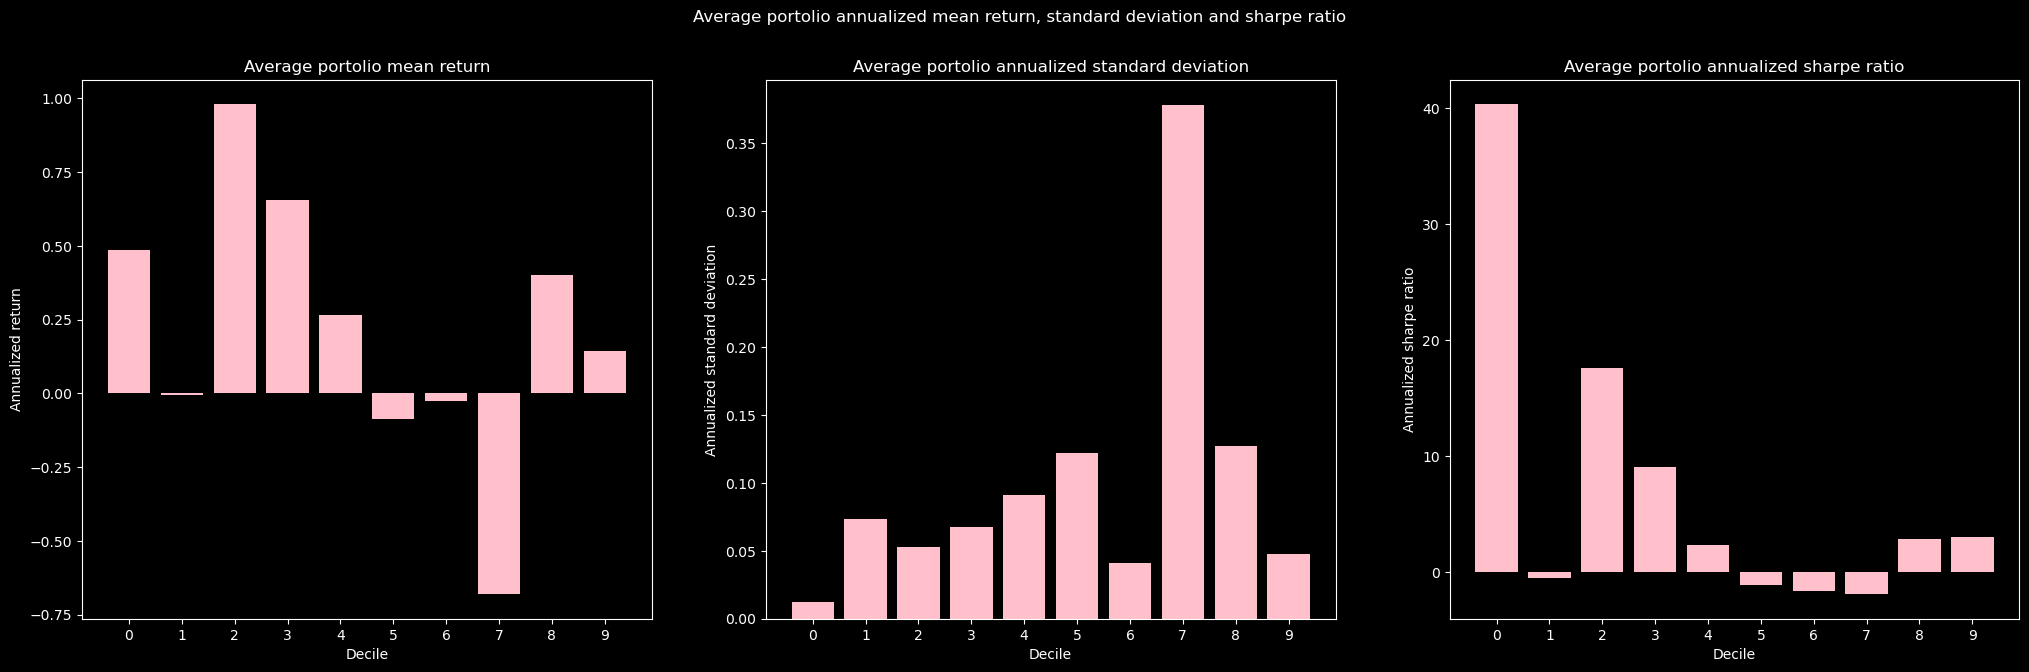

In [19]:
# Plot average annualized portfolio mean, std, sharpe ratio
deciles = list(data_Qb.monthly_decile.unique())
deciles.sort()

MEAN, STD, SR = [], [], []

for decile in deciles:
    d = data_Qb[data_Qb["monthly_decile"] == decile].head(2)
    rf = d["tmytm"].mean() * 12
    mean = d["monthly_return"].mean() * 12
    std = d["monthly_return"].std() * np.sqrt(12)
    sr = (mean - rf) / std
    MEAN.append(mean)
    STD.append(std)
    SR.append(sr)


# Plot the results
fig, axs = plt.subplots(1, 3, figsize=(25, 7), sharey=False)
plot_color = "pink"

axs[0].bar(deciles, MEAN, color=plot_color)
axs[0].set_title("Average portolio mean return")
axs[0].set_xticks(deciles)
axs[0].set_xlabel("Decile")
axs[0].set_ylabel("Annualized return")

axs[1].bar(deciles, STD, color=plot_color)
axs[1].set_title("Average portolio annualized standard deviation")
axs[1].set_xticks(deciles)
axs[1].set_xlabel("Decile")
axs[1].set_ylabel("Annualized standard deviation")

axs[2].bar(deciles, SR, color=plot_color)
axs[2].set_title("Average portolio annualized sharpe ratio")
axs[2].set_xticks(deciles)
axs[2].set_xlabel("Decile")
axs[2].set_ylabel("Annualized sharpe ratio")

plt.suptitle('Average portolio annualized mean return, standard deviation and sharpe ratio')
plt.savefig("Figures/question_3b_plot_decile_portfolios")
plt.show()

### NEED TO ADD THE LAST PART OF THE QUESTION